In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 7.0]
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import FunctionTransformer

from load_utils import load_data
from features import mean_of_var, wind_speed, wind_direction, all_features, k_diff
from CAPE_CNR_metric import CAPE_CNR_function
from models.sk_model import *
from models.lstm_models import *

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



## Train set

In [2]:
df, target = load_data()
true_prod = target.stack('WF')['Production']

In [3]:
features = all_features(df, get_diff=[1, 2, 3], test_set=True)

full_df = pd.concat([features, target], axis=1)

full_df_wfs = list(map(lambda df: df.drop('Production', axis=1), split_data_wf(full_df)))

In [4]:
prod_df_wfs = list(map(lambda features_df: features_df['Production'], split_data_wf(full_df)))
prod_wfs = list(map(lambda df: df.to_numpy(), prod_df_wfs))

In [5]:
def get_CAPE(true_prod, model_pred):
    """ Compute CAPE loss with comparable datasets (remove NaN and keep common indices) """
    true_prod_model = true_prod[model_pred.index]                  
    true_prod_model = true_prod_model[~true_prod_model.isna()]     
    model_pred_final = model_pred[true_prod_model.index]
    return CAPE_CNR_function(true_prod_model.values, model_pred_final.values)

### Sk model

#### Train regressor

In [6]:
model = SGDRegressor
parameters = dict(loss='huber', penalty='l2', alpha=0.0001,
                  fit_intercept=True, max_iter=200, tol=0.001,)
parameters = {f"model__{k}": [v] for k, v in parameters.items()}

# model = MLPRegressor
# parameters = {'model__alpha': 10.0 ** np.arange(-5, -4),
#                'model__hidden_layer_sizes': [(100,) * i for i in range(1, 2)]}

sk_regressor_full = SkRegressorIndividual(model, parameters)
sk_regressor_full.fit(full_df)

[W 200324 11:09:12 sk_model:84] Some target values are Nan! Removing specific lines...
[I 200324 11:09:12 sk_model:210] Fit on WF 1
[I 200324 11:09:12 sk_model:228] score on test = 48.62
[D 200324 11:09:12 sk_model:229] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200324 11:09:12 sk_model:210] Fit on WF 2
[I 200324 11:09:12 sk_model:228] score on test = 35.11
[D 200324 11:09:12 sk_model:229] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200324 11:09:12 sk_model:210] Fit on WF 3
[I 200324 11:09:12 sk_model:228] score on test = 34.71
[D 200324 11:09:12 sk_model:229] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200324 11:09:12 sk_model:210] Fit on WF 4
[I 200324 11:09:12 sk_mod

#### Make predictions

In [7]:
sk_predictions = sk_regressor_full.predict(full_df)

In [8]:
print("Sk model prediction score: {:.2f}".format(get_CAPE(true_prod, sk_predictions)))

Sk model prediction score: 38.00


In [9]:
sk_predictions_unstack = sk_predictions.unstack('WF')
sk_predictions_unstack.head()

WF                          1         2         3         4         5  \
Time                                                                    
2018-05-05 00:00:00  0.224891  2.796733  3.050932  1.134069  1.142409   
2018-05-05 01:00:00  0.116581  2.563294  3.242069  1.302063  0.703826   
2018-05-05 02:00:00  0.024727  2.523549  3.528307  1.408764  0.556480   
2018-05-05 03:00:00  0.026619  2.780391  3.746703  1.371423  0.632919   
2018-05-05 04:00:00  0.000000  2.798810  3.847772  1.317936  0.610860   

WF                          6  
Time                           
2018-05-05 00:00:00  1.130258  
2018-05-05 01:00:00  1.123819  
2018-05-05 02:00:00  1.039912  
2018-05-05 03:00:00  0.831782  
2018-05-05 04:00:00  0.747786

In [10]:
from load_utils import add_ID_column

sk_predictions = add_ID_column(sk_predictions)

[W 200324 11:09:17 load_utils:43] These values are in the prediction Series but not in the ID Serie (59)
    MultiIndex([('2018-05-11 09:00:00', 5),
                ('2018-05-11 10:00:00', 5),
                ('2018-05-11 11:00:00', 5),
                ('2018-08-20 07:00:00', 5),
                ('2018-08-20 08:00:00', 5),
                ('2018-09-22 11:00:00', 5),
                ('2018-09-22 12:00:00', 5),
                ('2018-09-22 13:00:00', 5),
                ('2018-09-22 14:00:00', 5),
                ('2018-09-22 15:00:00', 5),
                ('2018-09-22 16:00:00', 5),
                ('2018-09-22 17:00:00', 5),
                ('2018-09-22 18:00:00', 5),
                ('2018-09-22 19:00:00', 5),
                ('2018-09-22 20:00:00', 5),
                ('2018-09-22 21:00:00', 5),
                ('2018-09-22 22:00:00', 5),
                ('2018-09-22 23:00:00', 5),
                ('2018-09-23 00:00:00', 5),
                ('2018-09-23 01:00:00', 5),
               

In [11]:
sk_predictions.head()

ID  Production
Time                WF                   
2018-01-05 01:00:00 1       1         NaN
                    2    6240         NaN
                    3   12479         NaN
                    4   18718         NaN
                    5   24957         NaN

In [12]:
sk_predictions.to_csv('data/test.csv', index=False)

### LSTM

In [48]:
features = all_features(df, get_diff=[], test_set=True) # no diff to compute

full_df = pd.concat([features, target], axis=1)

#### Load model

In [78]:
lstm_regressor = LstmRegressor({}, shift=24, id="mean_24")

#### Make predictions

In [52]:
lstm_predictions = lstm_regressor.predict(full_df)

In [53]:
prod_wfs_cape = np.vstack(prod_wfs).flatten('F')
lstm_predictions_cape = np.vstack(lstm_predictions).flatten('F')
lstm_predictions_cape = lstm_predictions_cape[~np.isnan(prod_wfs_cape)]
prod_wfs_cape = prod_wfs_cape[~np.isnan(prod_wfs_cape)]

In [54]:
print("LSTM model prediction score: {:.2f}".format(CAPE_CNR_function(prod_wfs_cape, lstm_predictions_cape)))

LSTM model prediction score: 39.51


### Compare on train

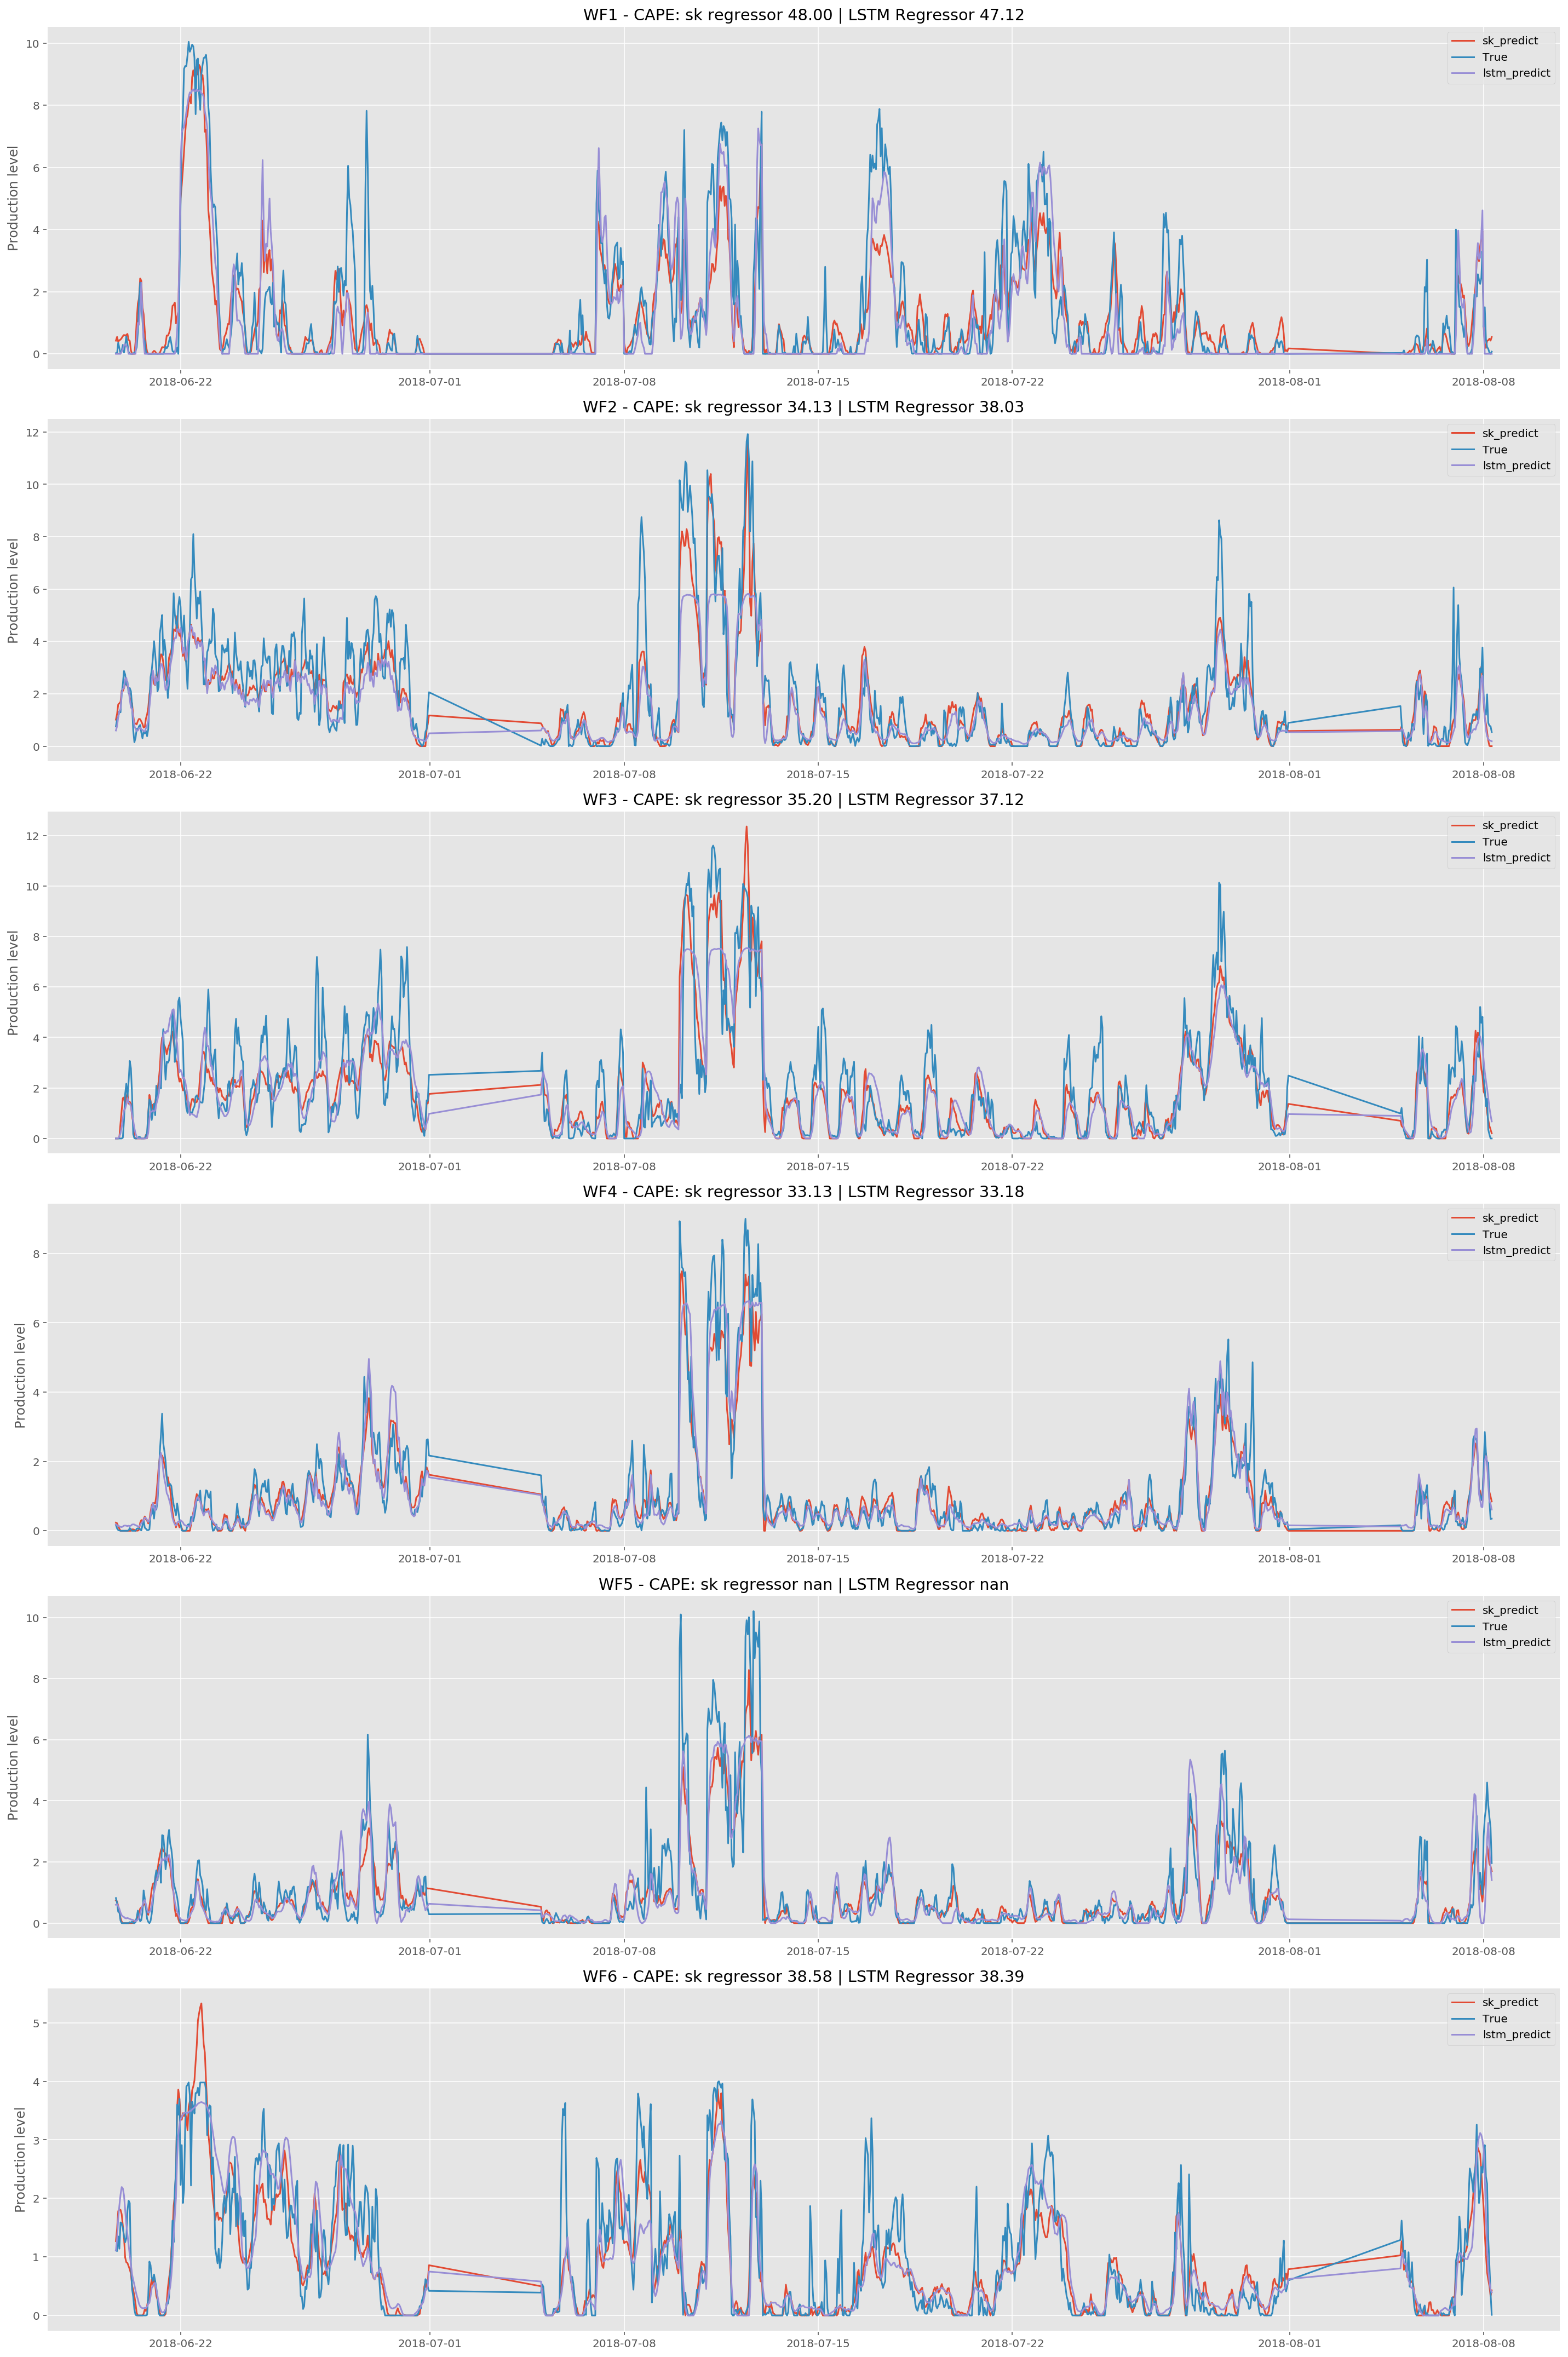

In [55]:
window = slice(1000, 2000)
fig, axes = plt.subplots(6, 1, figsize = (20, 5 * 6))
for i, ax in enumerate(axes):
    ax.plot(sk_predictions_unstack.index[window], sk_predictions_unstack[i+ 1].values[window], label='sk_predict')
    ax.plot(sk_predictions_unstack.index[window], prod_wfs[i][window], label='True')
    ax.plot(sk_predictions_unstack.index[window], lstm_predictions[i][window], label='lstm_predict')
    ax.legend()
    ax.set_ylabel('Production level')
    ax.set_title(f"WF{i + 1} - CAPE: sk regressor {CAPE_CNR_function(prod_wfs[i], sk_predictions_unstack[i + 1]):.2f} | LSTM Regressor {CAPE_CNR_function(prod_wfs[i], lstm_predictions[i]):.2f}")
plt.tight_layout()

fig.savefig('images/train_predictions.png')

plt.show()

## On test

#### load test sets

In [56]:
df_test = load_data('data/X_test_v2.csv', path_Y=None, crop_train_period=False)
random_y = pd.read_csv('data/Y_test_random.csv')

# Brut data - will be used for submissions
brut_test = pd.read_csv('data/X_test_v2.csv')
brut_test.index = brut_test['ID']
brut_test = brut_test[['Time', 'WF']]
brut_test['Time'] = pd.to_datetime(brut_test['Time'])
brut_set_index = set()
for couple in brut_test[['Time', 'WF']].values:
    brut_set_index.add((couple[0], couple[1]))

### Make predictions
#### Sk model

In [27]:
features_test_sk = all_features(df_test, get_diff=[1, 2, 3], test_set=True)

In [28]:
test_predictions_sk = sk_regressor_full.predict(features_test_sk)
test_predictions_sk_unstack = test_predictions_sk.unstack('WF')

#### /!\ Submission format /!\

In [29]:
# should be stacked like this:
test_predictions_sk

Time                 WF
2019-01-02 00:00:00  1     3.722827
                     2     3.538266
                     3     4.243605
                     4     2.533350
                     5     2.540463
                             ...   
2019-12-09 23:00:00  2     1.343598
                     3     0.673706
                     4     0.730246
                     5     1.057602
                     6     0.439523
Length: 37158, dtype: float64

In [57]:
def make_submission(stacked_pred, brut_df, brut_df_set_index):
    """ Take stacked predictions (stacked_pred) and return a DataFrame with good indices (reference for indices being found in brut_df) """
    pred_ = []
    ind = []
    for time, wf in tqdm(stacked_pred.index):
        wff = 'WF' + str(wf)
        if (time, wff) in brut_df_set_index:
            pred_.append(stacked_pred[(time, wf)])
            ind.append(brut_df[(brut_df.Time == time) & (brut_df.WF == wff)].index[0])
            
    pred_ = np.array(pred_)
    ind = np.array(ind)
    aux = np.argsort(ind)
    pred_ = pred_[aux]
    ind = ind[aux]
    
    pred_ = pd.DataFrame( pred_, columns=['Production'], index=ind)

    pred_.index = pred_.index.astype('int')
    return pred_

In [558]:
sk_df_sub = make_submission(test_predictions_sk, brut_test, brut_set_index)




  0%|          | 0/37158 [00:00<?, ?it/s]


  0%|          | 34/37158 [00:00<01:50, 336.35it/s]


  0%|          | 69/37158 [00:00<01:49, 340.05it/s]


  0%|          | 107/37158 [00:00<01:46, 348.69it/s]


  0%|          | 140/37158 [00:00<01:48, 342.58it/s]


  0%|          | 174/37158 [00:00<01:48, 339.52it/s]


  1%|          | 208/37158 [00:00<01:49, 337.99it/s]


  1%|          | 242/37158 [00:00<01:49, 338.29it/s]


  1%|          | 276/37158 [00:00<01:49, 337.12it/s]


  1%|          | 311/37158 [00:00<01:48, 338.76it/s]


  1%|          | 346/37158 [00:01<01:48, 339.18it/s]


  1%|          | 382/37158 [00:01<01:47, 342.97it/s]


  1%|          | 416/37158 [00:01<01:47, 340.22it/s]


  1%|          | 451/37158 [00:01<01:47, 342.75it/s]


  1%|▏         | 486/37158 [00:01<01:46, 344.13it/s]


  1%|▏         | 523/37158 [00:01<01:44, 350.82it/s]


  2%|▏         | 560/37158 [00:01<01:42, 356.02it/s]


  2%|▏         | 601/37158 [00:01<01:39, 369.23it/s]


  2%|▏         | 646

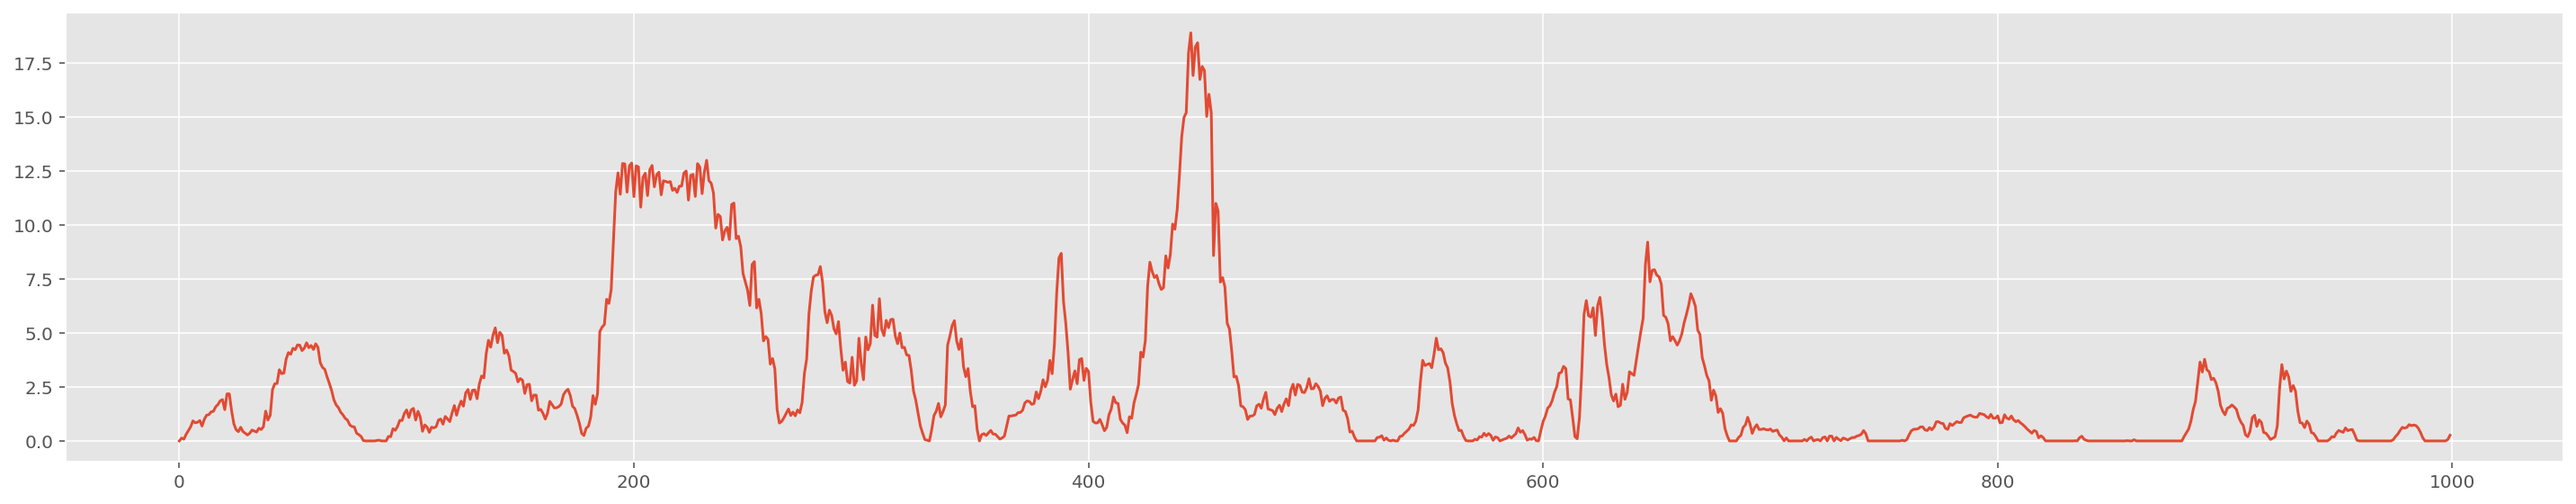

In [562]:
# should look good (sufficiently smooth)
plt.figure(figsize=(20, 4))
plt.plot(sk_df_sub.values[:1000])
plt.tight_layout()
plt.show()

##### Save submission

In [563]:
if np.all(sk_df_sub.index == random_y.ID):
    sk_df_sub.to_csv('predictions/test_sk.csv')
    print("saved")
else:
    print('A problem happened')

saved


#### LSTM model

In [79]:
features_test_lstm = all_features(df_test, get_diff=[], test_set=True)

In [80]:
test_predictions_lstm = lstm_regressor.predict(features_test_lstm)

In [81]:
test_predictions_lstm # one list corresponding to each WF

[array([2.6432483 , 4.0002418 , 5.81252   , ..., 0.42377028, 0.2872605 ,
        0.        ], dtype=float32),
 array([2.6228876, 3.4215622, 3.470194 , ..., 1.4069537, 1.4740914,
        1.3131528], dtype=float32),
 array([3.1484494 , 5.30152   , 6.2879033 , ..., 0.29212683, 0.40658474,
        0.4817881 ], dtype=float32),
 array([2.1067724 , 3.441719  , 3.6733115 , ..., 0.564742  , 0.57861155,
        0.5811546 ], dtype=float32),
 array([1.4035021 , 1.9800599 , 2.3303676 , ..., 0.6296733 , 0.58073163,
        0.6451196 ], dtype=float32),
 array([1.4434874 , 2.099437  , 2.3009996 , ..., 0.63287014, 0.53680396,
        0.45770937], dtype=float32)]

In [82]:
aux_lstm_test = features_test_lstm.stack('WF')
aux_lstm_test["Production"] = np.vstack(test_predictions_lstm).flatten("F")
aux_lstm_test = aux_lstm_test['Production']
aux_lstm_test # stacked data

Time                 WF
2019-01-02 00:00:00  1     2.643248
                     2     2.622888
                     3     3.148449
                     4     2.106772
                     5     1.403502
                             ...   
2019-12-09 23:00:00  2     1.313153
                     3     0.481788
                     4     0.581155
                     5     0.645120
                     6     0.457709
Name: Production, Length: 37158, dtype: float32

In [83]:
lstm_df_test_sub = make_submission(aux_lstm_test, brut_test, brut_set_index)

100%|██████████| 37158/37158 [01:40<00:00, 368.78it/s]


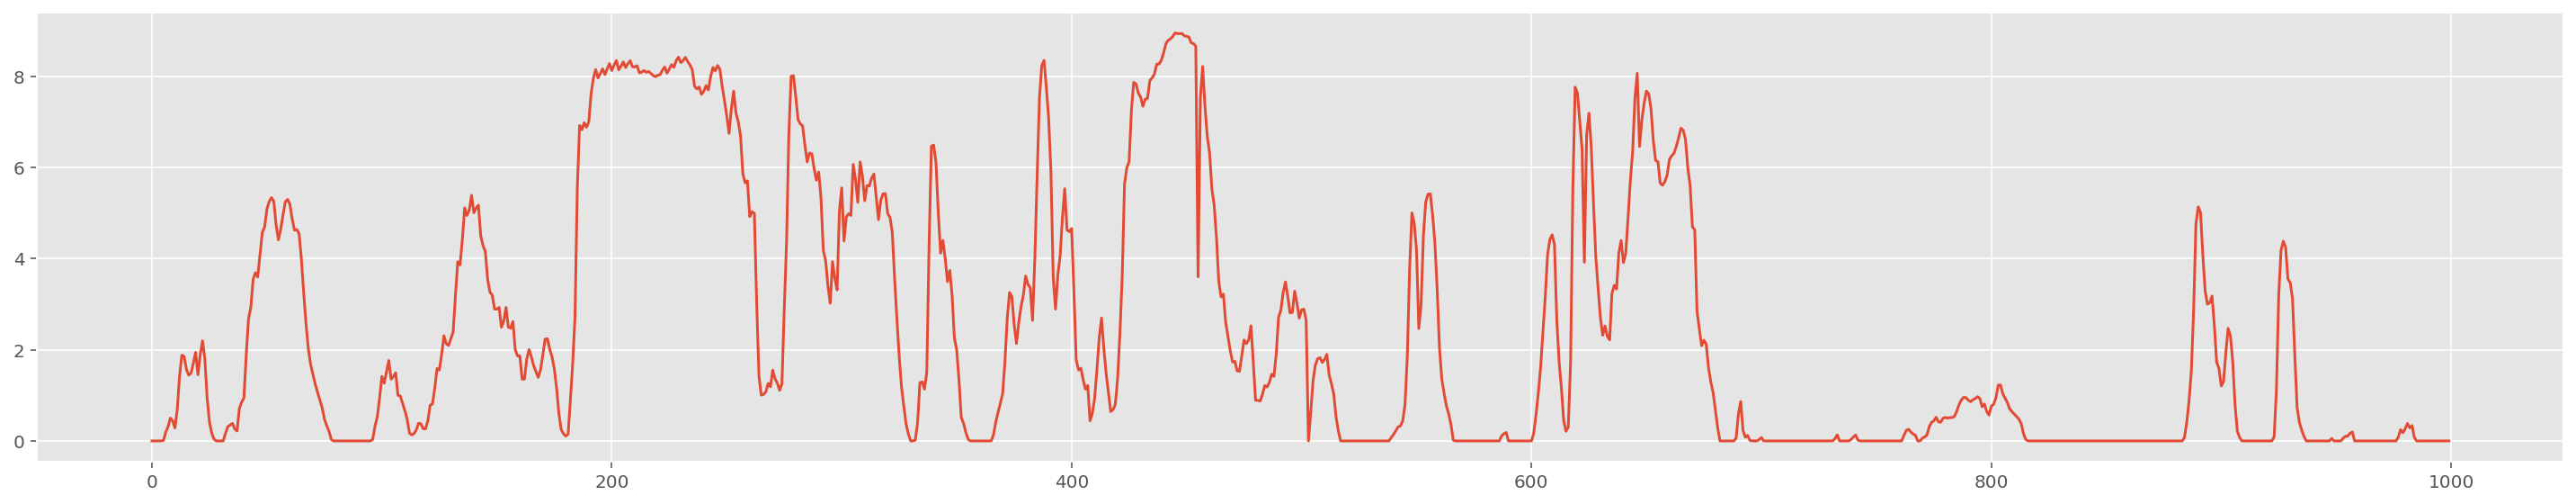

In [84]:
# should look good (sufficiently smooth)
plt.figure(figsize=(20, 4))
plt.plot(lstm_df_test_sub.values[:1000])
plt.tight_layout()
plt.show()

##### Save submission

In [85]:
if np.all(lstm_df_test_sub.index == random_y.ID):
    lstm_df_test_sub.to_csv('predictions/test_lstm.csv')
    print("saved")
else:
    print('A problem happened')

saved


#### Compare on test

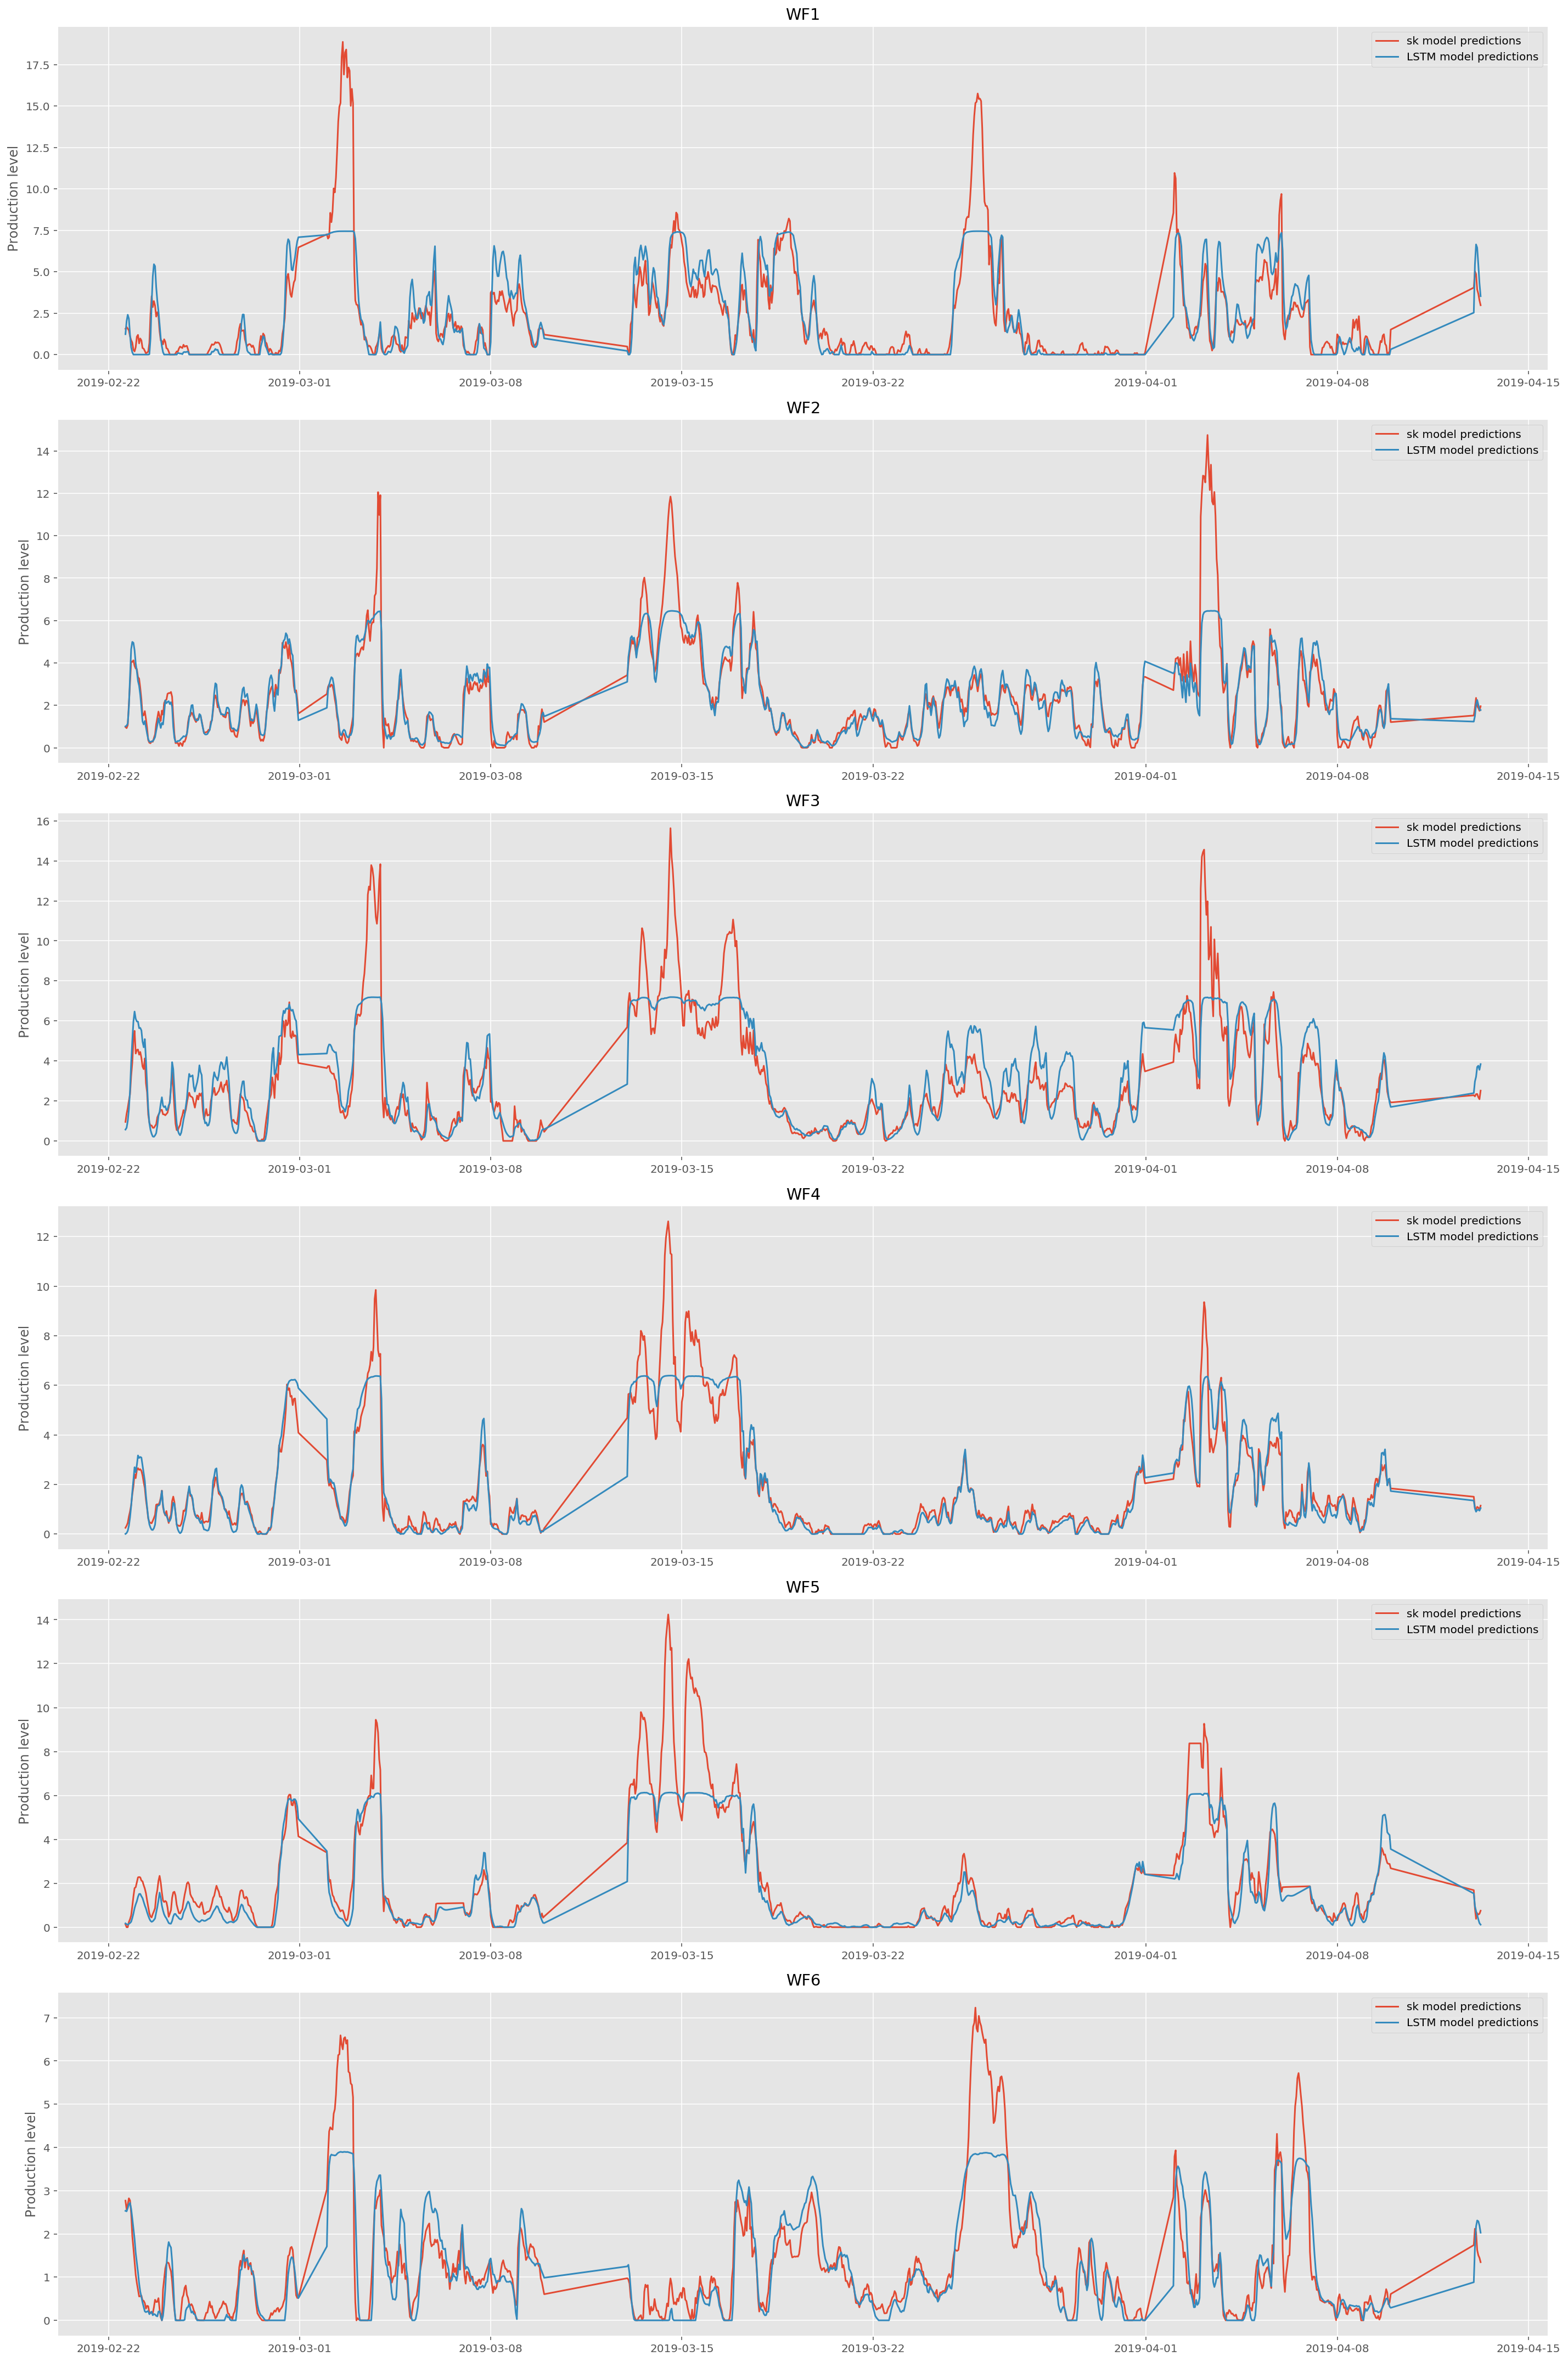

In [46]:
window = slice(1000, 2000)
fig, axes = plt.subplots(6, 1, figsize = (20, 5 * 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(test_predictions_sk_unstack.index[window], test_predictions_sk_unstack[i + 1].values[window], label='sk model predictions')
    ax.plot(test_predictions_sk_unstack.index[window], test_predictions_lstm[i][window], label='LSTM model predictions')
    ax.legend()
    ax.set_ylabel('Production level')
    ax.set_title(f'WF{i + 1}')
plt.tight_layout()
fig.savefig('images/test_predictions.png')
plt.show()